# 1. Imports

In [1]:
import os
import numpy as np
import pandas as pd
import imageio

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate


import matplotlib.pyplot as plt
%matplotlib inline

# 2. Load data

In [2]:
# image_path = '../data/people_segmentation/images'
# mask_path = '../data/people_segmentation/masks'

image_path = '../input/person-segmentation/people_segmentation/images'
mask_path = '../input/person-segmentation/people_segmentation/masks'

image_list = sorted(os.listdir(image_path))  # images are not sorted
mask_list = sorted(os.listdir(mask_path))
image_list = [image_path + "/" + i for i in image_list]
mask_list = [mask_path + "/" + i for i in mask_list]
print(image_list[0])
print(mask_list[0])

../input/person-segmentation/people_segmentation/images/IMG_3496bfree.jpg
../input/person-segmentation/people_segmentation/masks/IMG_3496bfree.png


Text(0.5, 1.0, 'Segmentation')

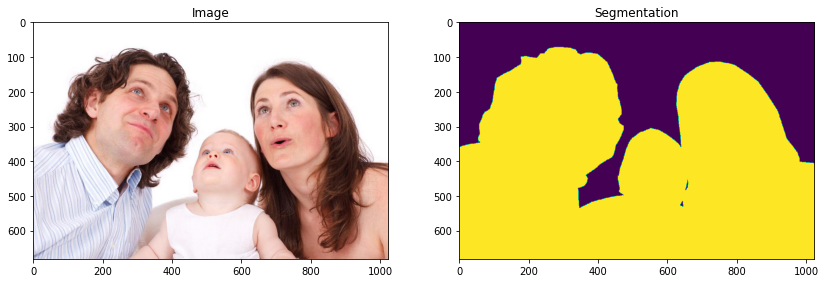

In [3]:
N = 15
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

## Split data into masked and unmasked images

In [4]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

2022-02-23 01:46:56.321382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 01:46:56.330064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 01:46:56.330854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 01:46:56.332352: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

tf.Tensor(b'../input/person-segmentation/people_segmentation/images/IMG_3496bfree.jpg', shape=(), dtype=string)
tf.Tensor(b'../input/person-segmentation/people_segmentation/masks/IMG_3496bfree.png', shape=(), dtype=string)


## Image Preprocessing
I will transform images and masks to tensor and then resizing to a smaller size to speed up computation.

In [5]:
IMAGE_SIZE = (320, 320)

def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) / 255  # since it is a jpg file
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1,)  # by default has 2 dimensions (0's and 1's), we want grayscale
    mask = tf.image.convert_image_dtype(mask, tf.uint8)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, IMAGE_SIZE, method='nearest')
    input_mask = tf.image.resize(mask, IMAGE_SIZE, method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
print(processed_image_ds)

<MapDataset shapes: ((320, 320, 3), (320, 320, 1)), types: (tf.float32, tf.uint8)>


# 3. U-Net Architecture
## Encoder (Convolutional Blocks)

In [6]:
def encoder_block(inputs=None, n_filters=32, dropout=0, max_pooling=True):
    """
    Convolutional encoder block
    
    Parameters
    ----------
    inputs: tensor
        Input tensor
    n_filters: int 
        Number of convolutional layer channels
    dropout: float
        Dropout probability between 0 and 1
    max_pooling: bool
        Whether to MaxPooling2D for spatial dimensions reduction
        
    Returns
    -------
    next_layer, skip_connection
        Next layer for the downsampling section and skip connection outputs
    """

    conv = Conv2D(filters=n_filters, 
                  kernel_size=3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(filters=n_filters, 
                  kernel_size=3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    # Add dropout if existing
    if dropout > 0:
        conv = Dropout(dropout)(conv)
         
        
    # Add MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
    else:
        next_layer = conv
    
    skip_connection = conv  # excluding maxpool from skip connection
    
    return next_layer, skip_connection

## Decoder (Upsampling) Blocks

In [7]:
def decoder_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional decoder block
    
    Parameters
    ----------
    expansive_input: tensor
        Input tensor
    contractive_input: tensor
        Input tensor from matching encoder skip layer
    n_filters: int
        Number of convolutional layers' channels
        
    Returns
    -------
    conv 
        Tensor of output layer
    """
    
    up = Conv2DTranspose(
                 filters=n_filters,
                 kernel_size=(3,3),
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    # The order of concatenation for channels doesn't matter
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(filters=n_filters, 
                  kernel_size=3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)
    conv = Conv2D(filters=n_filters, 
                  kernel_size=3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    return conv

# 4. Building U-Net
This is where everything is put together, by chaining the encoder, bottleneck, and decoder. We will need to specify the number of output channels, which for this particular set would be 1 (person segmentation only). That's because there is only 1 possible label for each pixel (0 or 1) in this person's dataset. The function below, however, allows for more filters in case more labels were provided in the dataset.

In [8]:
def U_Net(input_size=(320, 320, 3), n_filters=32, n_classes=1):
    """
    U_Net model
    
    Parameters
    ----------
    input_size: tuple of integers
        Input image dimension 
    n_filters: int
        Number of convolutional layer channels
    n_classes: int
        Number of output classes
        
    Returns
    -------
    model
        tensorflow model
    """
    inputs = Input(input_size)
    
    # Encoder section
    #################
    # Double the number of filters at each new step
    # The first element of encoder_block is input to the next layer 
    eblock1 = encoder_block(inputs, n_filters)
    eblock2 = encoder_block(eblock1[0], n_filters * 2)
    eblock3 = encoder_block(eblock2[0], n_filters * 4)
    eblock4 = encoder_block(eblock3[0], n_filters * 8, dropout=0.3)
    eblock5 = encoder_block(eblock4[0], n_filters * 16, dropout=0.3, max_pooling=False) 
    
    
    # Decoder section
    #################
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output
    # The second element of encoder_block is input to the skip connection 
    # Halving the number of filters of the previous block in each section
    dblock6 = decoder_block(expansive_input=eblock5[1], contractive_input=eblock4[1], n_filters=n_filters * 8)
    dblock7 = decoder_block(expansive_input=dblock6, contractive_input=eblock3[1], n_filters=n_filters * 4)
    dblock8 = decoder_block(expansive_input=dblock7, contractive_input=eblock2[1], n_filters=n_filters * 2)
    dblock9 = decoder_block(expansive_input=dblock8, contractive_input=eblock1[1], n_filters=n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(dblock9)

    # Add a 1x1 Conv2D (projection) layer with n_classes filters to adjust number of output channels
    conv10 = Conv2D(filters=n_classes, kernel_size=1, padding='same')(conv9)
    pred = tf.keras.activations.sigmoid(conv10)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [9]:
# Checking summary stats
unet = U_Net((320, 320, 3), n_filters=32, n_classes=1)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 160, 160, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Define Loss function

In the Person's dataset each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability. We will use sparse categorical crossentropy as loss function, to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with lots of classes.

In [10]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In case of more than 1 category it is faster if we use sparse categorical cross entropy due to the sparsity of the mask file.

In [11]:
# # If using more than one category
# unet.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# 5. Training the Model

In [12]:
EPOCHS = 40
BUFFER_SIZE = 50
BATCH_SIZE = 64
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

Num GPUs Available:  1
(TensorSpec(shape=(320, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(320, 320, 1), dtype=tf.uint8, name=None))
Epoch 1/40


2022-02-23 01:46:58.747707: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-23 01:47:00.607085: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-02-23 01:47:08.463450: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-23 01:47:08.586934: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-23 01:47:08.652906: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying t

89/89 [==============================] - 185s 2s/step - loss: 0.8720 - accuracy: 0.7317
Epoch 2/40
89/89 [==============================] - 91s 1s/step - loss: 0.5180 - accuracy: 0.7508
Epoch 3/40
89/89 [==============================] - 91s 1s/step - loss: 0.4980 - accuracy: 0.7584
Epoch 4/40
89/89 [==============================] - 91s 1s/step - loss: 0.4576 - accuracy: 0.7805
Epoch 5/40
89/89 [==============================] - 91s 1s/step - loss: 0.4091 - accuracy: 0.8111
Epoch 6/40
89/89 [==============================] - 91s 1s/step - loss: 0.3601 - accuracy: 0.8409
Epoch 7/40
89/89 [==============================] - 91s 1s/step - loss: 0.3441 - accuracy: 0.8480
Epoch 8/40
89/89 [==============================] - 91s 1s/step - loss: 0.3210 - accuracy: 0.8643
Epoch 9/40
89/89 [==============================] - 91s 1s/step - loss: 0.3060 - accuracy: 0.8719
Epoch 10/40
89/89 [==============================] - 91s 1s/step - loss: 0.2884 - accuracy: 0.8789
Epoch 11/40
89/89 [==========

## Model Accuracy

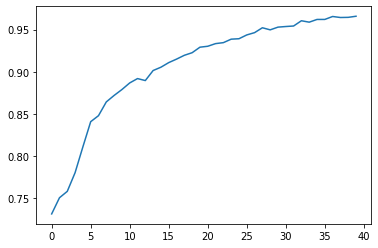

In [13]:
plt.plot(model_history.history["accuracy"])

# Showing Predictions

In [14]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [15]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    for image, mask in dataset.take(num):
        pred_mask = unet.predict(image) > 0.5
        display([image[0], mask[0], pred_mask[0]])

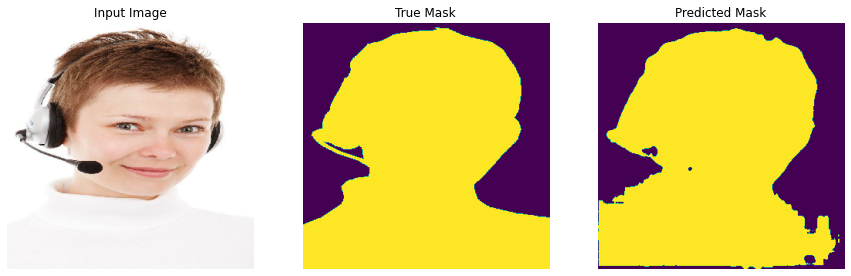

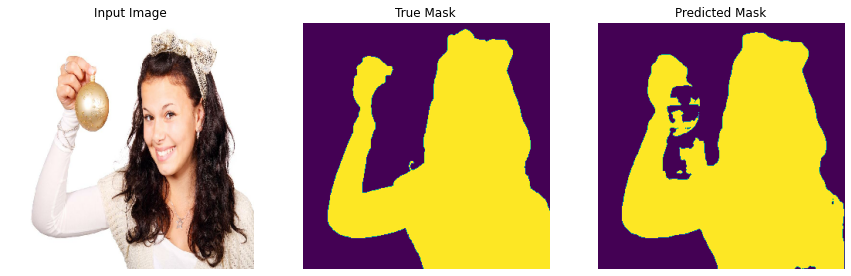

In [16]:
show_predictions(train_dataset, 2)

# 6. Save model

In [17]:
unet.save("./Unet_model2.h5")

# 7. Load model and prediction

In [18]:
new_model = tf.keras.models.load_model('../input/unet-model/Unet_model.h5')

In [19]:
IMAGE_PATH = "../input/example/pexels-photo-1239291.jpeg"
IMAGE_SIZE = (192, 256)

def process_path(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) / 255  # since it is a jpg file
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img

def preprocess(image):
    input_image = tf.image.resize(image, IMAGE_SIZE, method='nearest')
    input_image = input_image[tf.newaxis, ...]

    return input_image

image_ds = process_path(IMAGE_PATH)
processed_image_ds = preprocess(image_ds)

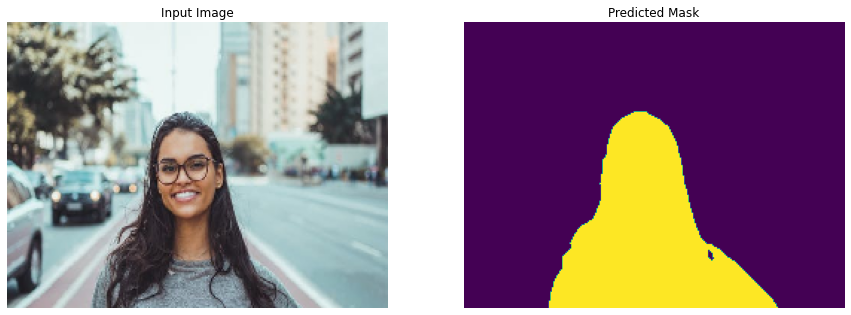

In [20]:
photo_mask = new_model.predict(processed_image_ds) > 0.5

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
display([processed_image_ds[0], photo_mask[0]])

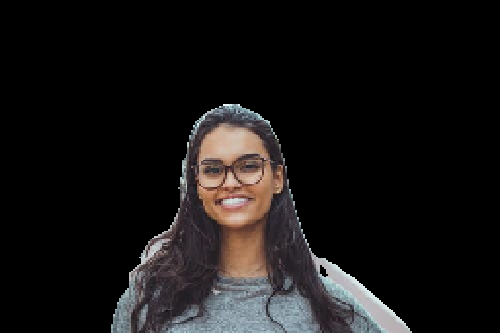

In [21]:
photo_mask = new_model.predict(processed_image_ds) > 0.5
background_mask = np.abs(1 - photo_mask)


original_img = tf.image.decode_jpeg(tf.io.read_file(IMAGE_PATH))
h, w, _ = original_img.shape



masked_photo = processed_image_ds * photo_mask
background_mask = np.concatenate([background_mask, background_mask, background_mask], axis=-1)
background_mask = background_mask * [0, 0, 255]
final_photo = masked_photo


tf.keras.preprocessing.image.array_to_img(tf.squeeze(tf.image.resize(final_photo, [h, w], method="nearest")))